In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandahouse as ph
import scipy.stats
import pingouin as pg
from matplotlib import pyplot as plt

import os
from dotenv import load_dotenv

load_dotenv()

In [63]:
#подключимся к датасету через clickhouse
connection = {
    'host': os.getenv('CLICKHOUSE_HOST'),
    'password': os.getenv('CLICKHOUSE_PASSWORD'),
    'user': os.getenv('CLICKHOUSE_USER'),
    'database': os.getenv('CLICKHOUSE_DATABASE')
}

Прежде чем анализировать результат A/B эксперимента между группой 2 и 1 убедимся, что работа системы сплитования была выстроена корректно, и ключевая метрика CTR до эксперимента не отличается в группах.

Для этого:

 - Возьмем данные АА-теста из доэкспериментального диапазона: с '2024-09-20' по '2024-09-26'

 - Из групп 2 и 1 возьмём подвыборки без возвращения размером в 500 пользователей

 - Сравним их t-тестом и сохраним p-value

 - Повторим это 10000 раз

 - Нарисуем гистограмму получившихся p-value и посчитаем долю p-value, оказавшихся ниже порога значимости в 0.05.

In [64]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-09-20' and '2024-09-26'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df_aa = ph.read_clickhouse(q, connection=connection)
df_aa

,exp_group,user_id,likes,views,ctr
0,1,109963,10,34,0.294118
1,1,18392,13,56,0.232143
2,2,131473,19,98,0.193878
3,2,23985,12,44,0.272727
4,2,24523,2,10,0.200000
...,...,...,...,...,...
16848,2,17146,23,194,0.118557
16849,1,132567,9,27,0.333333
16850,2,25383,2,18,0.111111
16851,2,108927,16,51,0.313725


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

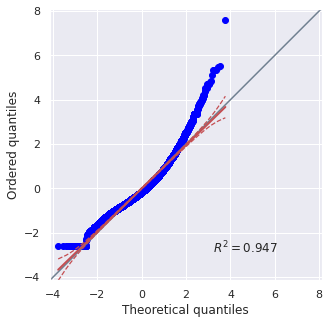

In [65]:
pg.qqplot(df_aa.query('exp_group == 1')['ctr'])

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

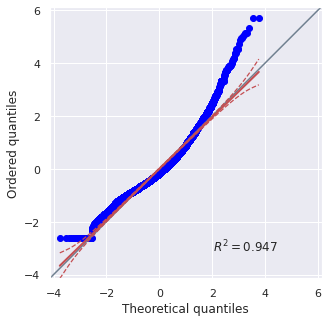

In [66]:
pg.qqplot(df_aa.query('exp_group == 2')['ctr'])

In [67]:
pg.normality(data=df_aa, dv="ctr", group="exp_group", method="shapiro")

/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
exp_group,,,
1,0.947013,0.0,False
2,0.947347,0.0,False


In [68]:
pg.homoscedasticity(data=df_aa, dv="ctr", group="exp_group")

,W,pval,equal_var
levene,0.031427,0.859293,True


Распределение CTR в группах до эксперимента ненормальное, дисперсии равны. Выборка достаточно большая, применяем t-тест.

In [69]:
pvalues = list()
sample_size = 500 # 500 пользователей
for _ in range(10000):
    # Случайная выборка 500 пользователей из каждой группы без возвращения
    sample_group2 = df_aa.query('exp_group == 2').sample(n=sample_size, replace=False)
    sample_group1 = df_aa.query('exp_group == 1').sample(n=sample_size, replace=False)
    p_value = scipy.stats.ttest_ind(sample_group2['ctr'], sample_group1['ctr'], equal_var=True)[1]
    pvalues.append(p_value)

In [70]:
pv_df_aa = pd.DataFrame(pvalues, columns=['p_value'])

<Axes: xlabel='p_value', ylabel='Count'>

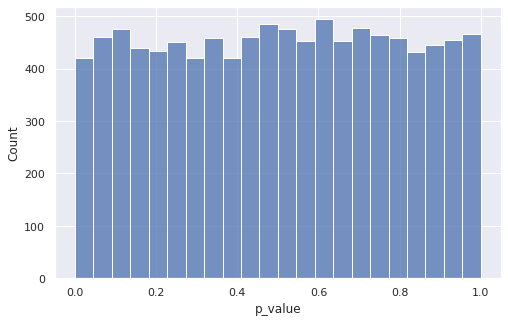

In [71]:
sns.histplot(data = pv_df_aa, 
              x='p_value')

In [72]:
((pv_df_aa['p_value'] < 0.05).sum()) / pv_df_aa['p_value'].count() # sum, т.к. метод возвращает булевы значения True(1) или False(0)

0.0472

Распределение p-value равномерно, доля p-value ниже порога значимости около 0.0472, т.е. только в 5 % случаев мы фиксируем ошибку 1 рода, значит, система сплитования работает корректно.

Теперь уже посмотрим на **CTR в тестовой и контрольной группах в даты проведения эксперимента с 2024-09-27 по 2024-10-03**.

In [73]:
# данные (количество, лайков, CTR) в тестовой и контрольной группах в даты проведения эксперимента
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-09-27' and '2024-10-03'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750
...,...,...,...,...,...
19892,1,132567,52,326,0.159509
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [74]:
# посмотрим на средний CTR в двух группах
df.groupby('exp_group')['ctr'].mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

Визуально кажется, что различия в метрике CTR в тестовой и контрольной группах есть. Однако, визуально CTR в тестовой группе немного ниже, чем в контрольной. Посмотрим, что на это "скажут" статистические тесты.

Прежде чем приступать к тестам, проверим данные на нормальность и равенство дисперсий.

<Axes: xlabel='ctr', ylabel='Count'>

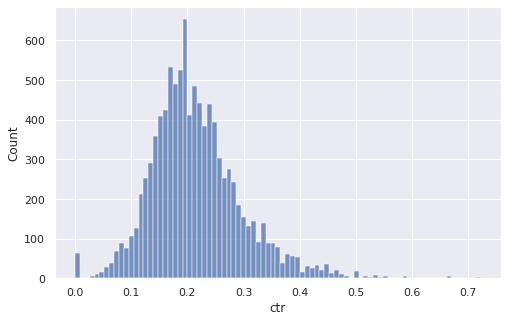

In [75]:
#построим гистограмму и посмотрим на CTR контрольной группы
control = df[df.exp_group == 1].copy()
sns.histplot(control.ctr, 
             kde = False)

<Axes: xlabel='ctr', ylabel='Count'>

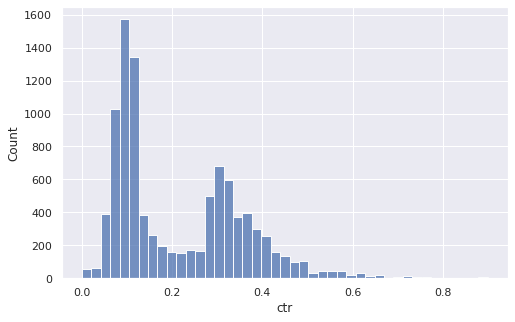

In [76]:
#посмотрим на CTR тестовой группы
test = df[df.exp_group == 2].copy()
sns.histplot(test.ctr, 
             kde = False)

B что мы видим? Распределение имеет две выраженные моды, оно бимодально, получается, что CTR в группе 2 при проведении теста частично вырос, но в то же время какая-то часть данной метрики наоборот просела.

На гистограммах видно, что распределения ненормальны (в контрольной есть болшой хвост, выбросы, про тестовую уже сказано выше), но проверим еще данные с помощью Шапиро-Уилка, а также сравним дисперсии в двух грппах.

In [77]:
pg.normality(data=df, dv="ctr", group="exp_group", method="shapiro")

/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/opt/conda/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
exp_group,,,
1,0.951870,0.0,False
2,0.893145,0.0,False


In [78]:
pg.homoscedasticity(data=df, dv="ctr", group="exp_group")

,W,pval,equal_var
levene,2757.794065,0.0,False


Распределение метрики CTR в обеих группах ненормальное, дисперсии не равны. Следовательно, для проведения первого теста по нашей метрике нужно будет взять t-тест с поправкой Уэлча на неравенство дисперсий.

**T-тест и тест Манна-Уитни**

In [79]:
# проведем T-test (сравним средний CTR в группах)
statistic, pvalue = scipy.stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 0.4051491913112757
p-значение: 0.685373331140751
Не отвергаем нулевую гипотезу. Средние значения выборок не различаются


In [80]:
# проведем тест Манна-Уитни (сравним, есть ли разница в распределении CTR в группах)
statistic, pvalue = scipy.stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Выбороки различаются")
else:
    print("Не отвергаем нулевую гипотезу. Выбороки не различаются")

статистика: 55189913.0
p-значение: 4.632205841806026e-45
Отвергаем нулевую гипотезу. Выбороки различаются


T-тест показал, что средние значения CTR в группах не различаются. А тест Манна-Уитни показал, что распределение метрики CTR различается между группами.

**Пуассоновский бутстреп**

<Axes: ylabel='Count'>

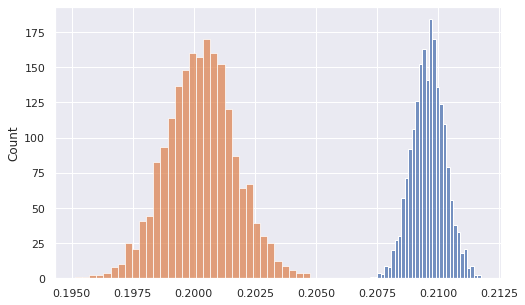

In [81]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = scipy.stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = scipy.stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

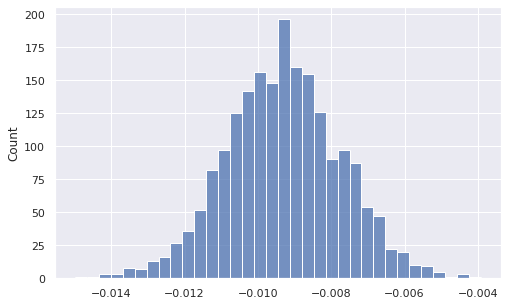

In [82]:
sns.histplot(ctr2 - ctr1)

Гистограмма разности не пересекает 0, разница между группами отрицательная и не нулевая, значит, контрольная группа показала лучший результат по CTR, чем тестовая группа.

**T-тест и тест Манна-Уитни поверх бакетного преобразования**

In [83]:
#распределяем пользователей по бакетам
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-09-27' and '2024-10-03'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_b = ph.read_clickhouse(q, connection=connection)
df_b

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632
...,...,...,...
95,2,47,0.196808
96,1,48,0.216369
97,2,48,0.194780
98,1,49,0.206288


Посмотрим на всякий случай на распределение и дисперсии нашего bucket_ctr в группах.

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

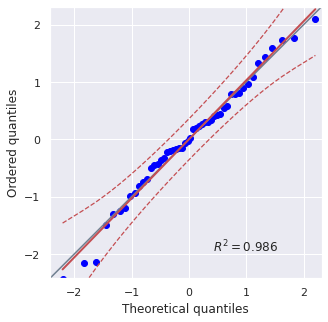

In [84]:
pg.qqplot(df_b.query('exp_group == 1')['bucket_ctr'])

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

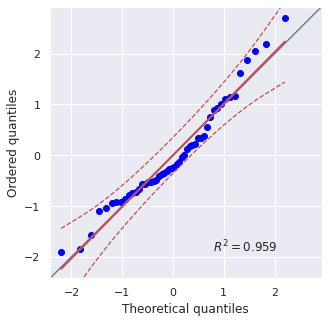

In [85]:
pg.qqplot(df_b.query('exp_group == 2')['bucket_ctr'])

In [86]:
pg.normality(data=df_b, dv="bucket_ctr", group="exp_group", method="shapiro")

,W,pval,normal
exp_group,,,
1,0.984154,0.734733,True
2,0.958589,0.077584,True


In [87]:
pg.homoscedasticity(data=df_b, dv="bucket_ctr", group="exp_group")

,W,pval,equal_var
levene,19.517796,0.000026,False


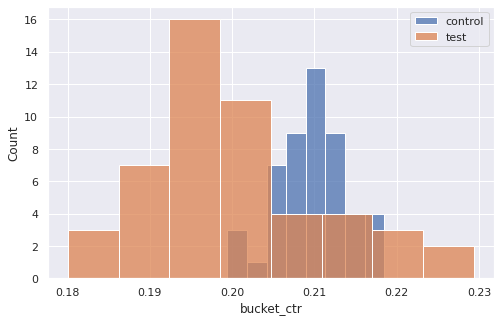

In [88]:
#на всякий случай посмотрим еще на побакетные CTR глазами:)
sns.set(rc={'figure.figsize':(8,5)})
sns.histplot(df_b[df_b.exp_group == 1].bucket_ctr, kde = False, label = "control")
sns.histplot(df_b[df_b.exp_group == 2].bucket_ctr, kde = False, label = "test")

plt.legend()

Распределение побакетного CTR в обеих группах нормальное ( + бимодальность в побакетном CTR не выражена), дисперсии не равны. Поскольку распределение побакетного CTR нормальное, то будем применять только t-тест с поправкой Уэлча на неравенство дисперсий. Тест Манна-Уитни использовать в данном случае нет смысла.

In [89]:
# T-test
statistic, pvalue = scipy.stats.ttest_ind(df_b[df_b.exp_group == 1].bucket_ctr,
                df_b[df_b.exp_group == 2].bucket_ctr,
                equal_var=False)

print(f"статистика: {statistic}")
print(f"p-значение: {pvalue}")

# Проверка статистической значимости
alpha = 0.05
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние значения выборок различаются")
else:
    print("Не отвергаем нулевую гипотезу. Средние значения выборок не различаются")

статистика: 5.614819358149381
p-значение: 4.592644937473873e-07
Отвергаем нулевую гипотезу. Средние значения выборок различаются


In [90]:
df_b.groupby('exp_group')['bucket_ctr'].mean()

exp_group
1    0.209694
2    0.200457
Name: bucket_ctr, dtype: float64

T-тест поверх бакетного преобразования показал,что средние побакетные CTR в группах различаются. Т.е. средний побакетный CTR в контрольной группе выше, чем в тестовой.

### Вывод

 - T-тест с поправкой Уэлча не показал разницу в средних значениях CTR между тестовой и контрольной группой, поскольку визуально средний CTR у двух групп +- схож, и проведенные изменения не были достаточно значительными, чтобы повлиять на средние.
 
 - Тест Манна-Уитни показал, что распределение метрики CTR между группами отличается. Вероятно, это объясняется тем, что разница в средних значениях CTR хоть статистически и не значима, но тест Манна-Уитни сравнивает именно распределение метрики, и он более чувствителен к различиям ее распределения (т.к. в тестовой группе распределение бимодально).

 - Пуассоновский бутстреп показал, что контрольная группа имеет лучший CTR, чем тестовая. Данный метод выдает более точный результат, так как он учитывает случайные вариации и устойчив к выбросам, бимодальности.

 - Бакетное преобразование свело к минимуму влияние выбросов и колебаний в данных (распределение побакетного CTR в обеих группах нормальное) и обеспечило более ровный анализ, в котором t-тест показал, что средний побакетный CTR в контрольной группе выше, чем в тестовой.

Основываясь на результатах проведенного анализа можно сделать вывод о том, что, в целом, различия в метрике CTR между тестовой и контрольной группами, либо отсутствуют, либо контрольная группа по данной метрике превосходит тестовую, что противоречит нашей изначальной гипотезе. Проведенный эксперимент можно считать неудачным, раскатывать новый алгоритм на всех пользователей не стоит. В дальнейшем требуется дополнительное исследование, направленное на выявление причины бимодальности в метрике CTR в тестовой группе (т.к. в ней CTR вырос только у части пользователей, а у другой части - наоборот упал).